In [15]:
from itertools import product

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from scipy import stats as sstats

import wandb

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)


def format_ticks(x, pos):
    return str(int(x / 1000))


wandb.login()
api = wandb.Api()

In [79]:
tiny_lora_weights = api.run("pico-lm/pico-relora/ixdq4sof")
small_lora_weights = api.run("pico-lm/pico-relora/a8nvp3mi")
baseline_tiny_weights = api.run("pico-lm/pico-relora/e8rwqdwk")
baseline_small_weights = api.run("pico-lm/pico-relora/evrk6fbj")

In [80]:
tlw = pd.DataFrame(tiny_lora_weights.scan_history())
btw = pd.DataFrame(baseline_tiny_weights.scan_history())

In [81]:
slw = pd.DataFrame(small_lora_weights.scan_history())
bsw = pd.DataFrame(baseline_small_weights.scan_history())

In [161]:
def get_across_ranges(df: pd.DataFrame, metric_name: str, *ranges):
    if not ranges:
        ranges = (range(12),)
    combos = product(*ranges)
    x = [df[metric_name.format(*combo)].replace("NaN", np.nan).to_numpy() for combo in combos]
    return np.column_stack(x)

In [6]:
TICK_LABEL_SIZE = 14
AXIS_LABEL_SIZE = 16

In [7]:
def plot_ld_metric(
    dfs: list[pd.DataFrame],
    metric_strs: list[str],
    x_title: str,
    y_title: str,
    file_name: str,
    *,
    yerr: bool = False,
    scatter: bool = True,
    every: list[int] = (1, 2, 1, 2),
):
    fig, ax = plt.subplots()

    colours = ["#1E88E5", "#FF992F", "#E81673", "#7A23DD"]
    err_colours = ["#6EADE5", "#FFBA73", "#E87BAB", "#B38DDD"]
    shapes = ["s", "o", "s", "o"]

    legend_elements = []

    for idx, df in enumerate(dfs):
        metricstr = metric_strs[idx]
        vs = get_across_ranges(df, metricstr)
        mu = np.mean(vs, axis=1, keepdims=True)
        sig = np.std(vs, axis=1, mean=mu, ddof=1)
        sem = sig / np.sqrt(vs.shape[1])
        ev = every[idx]
        xs = df["_step"].to_numpy()
        ax.errorbar(
            xs[::ev],
            np.squeeze(mu)[::ev],
            yerr=sem[::ev] if yerr else None,
            color=colours[idx],
            ecolor=err_colours[idx],
            capsize=1,
            elinewidth=1,
            # fmt=,
            markersize=3,
            zorder=3,
        )

        if scatter:
            ax.scatter(
                xs[::ev],
                np.squeeze(mu)[::ev],
                color=colours[idx],
                s=10,
                marker=shapes[idx],
                zorder=5,
            )

        legend_elements.append(
            Line2D(
                [0],
                [0],
                color=colours[idx],
                marker=shapes[idx] if scatter else None,
                linestyle="-",
                label=r"\texttt{"
                f"pico-{'decoder' if idx % 2 == 0 else 'relora'}-"
                f"{'tiny' if idx < 2 else 'small'}}}",
                markersize=5,
            )
        )

    ax.set_xticks(np.arange(0, 20_001, 1_000), labels=[str(i) for i in range(21)])
    ax.set_xlim(-300, 20_300)
    ax.set_axisbelow(True)
    ax.grid(which="major", axis="both", color="#E5E5E5")

    ax.tick_params("both", labelsize=TICK_LABEL_SIZE)

    ax.legend(handles=legend_elements, fontsize=TICK_LABEL_SIZE)

    ax.set_xlabel(x_title, fontdict={"size": AXIS_LABEL_SIZE})
    ax.set_ylabel(y_title, fontdict={"size": AXIS_LABEL_SIZE})

    fig.tight_layout()
    fig.show()
    fig.savefig(f"../graphs/{file_name}.pdf")

# Swiglu PER

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_28687/612548298.py:78: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


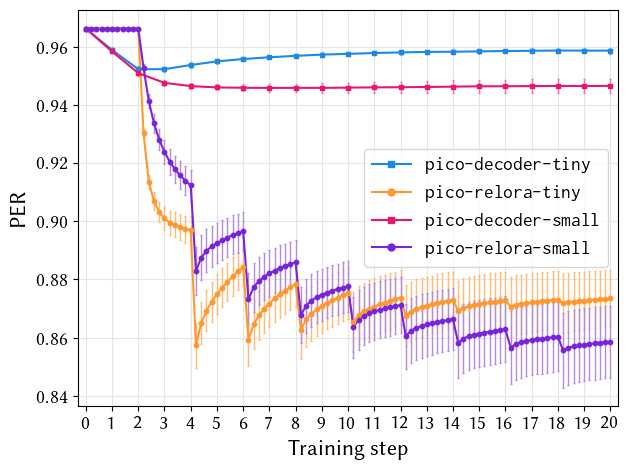

In [ ]:
plot_ld_metric(
    (btw, tlw, bsw, slw),
    [
        f"per_val/_forward_module.module.layers.{{}}.swiglu.w_2.{'full.' if idx % 2 == 1 else ''}weights"
        for idx in range(4)
    ],
    "Training step",
    "PER",
    "swiglu_per",
    yerr=True,
)

# OV circuit PER

In [9]:
tiny_ov_base = api.run("pico-lm/pico-relora/ep4hgu2s")
small_ov_base = api.run("pico-lm/pico-relora/1p445avk")

In [10]:
tob = pd.DataFrame(tiny_ov_base.scan_history())
sob = pd.DataFrame(small_ov_base.scan_history())

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_28687/612548298.py:78: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


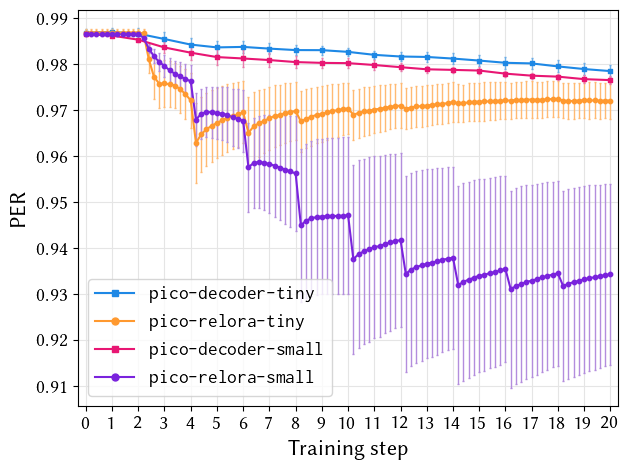

In [11]:
plot_ld_metric(
    (tob, tlw, sob, slw),
    [
        f"per_val/_forward_module.module.layers.{{}}.ov_circuit.{'full.' if idx % 2 == 1 else ''}weights"
        for idx in range(4)
    ],
    "Training step",
    "PER",
    "ov_circuit_per",
    yerr=True,
    scatter=True,
)

# Hoyer

In [17]:
def get_data_from_df(df: pd.DataFrame, every: int = 100, max_step: int = 20_000):
    global_step = df["trainer/global_step"]
    filtered = df.filter(like="by_phenomenon", axis=1).copy().dropna().drop_duplicates()
    filtered.columns = filtered.columns.map(lambda x: x.split(".")[1])
    filtered["step"] = global_step
    steps = filtered["step"]
    mask = (steps <= max_step) & (steps % every == 0)
    return filtered[mask]

In [ ]:
relora_run_tiny = api.run("pico-lm/pico-relora/6vhmv4aj")
raw_data = pd.DataFrame(relora_run_tiny.scan_history())

In [132]:
relora_run_small = api.run("pico-lm/pico-relora/5urfvs2j")
raw_data_small = pd.DataFrame(relora_run_small.scan_history())

In [85]:
import json
from pathlib import Path

In [86]:
def load_blimp_data(path: Path) -> dict:
    with path.open() as f:
        data = json.load(f)
    if "blimp" in data:
        data = data["blimp"]
    return data


def get_uids(data: dict):
    return np.array(list(data["by_uid"].values()))

In [302]:
SCALE = "tiny"

base_phens = []
steps = list(range(0, 20_001, 1_000))
for i in steps:
    baseline_data = load_blimp_data(Path(f"blimp_results_{SCALE}/step_{i}.json"))
    d = baseline_data["by_phenomenon"]
    d["step"] = i
    base_uids = base_phens.append(d)

base_phens = pd.DataFrame(base_phens)


relora_data = get_data_from_df(raw_data_small if SCALE == "small" else raw_data)
relora_data.tail()

,argument_structure,island_effects,ellipsis,determiner_noun_agreement,binding,filler_gap_dependency,npi_licensing,irregular_forms,subject_verb_agreement,control_raising,anaphor_agreement,s-selection,quantifiers,step
13440,0.639000,0.520625,0.5580,0.801750,0.684143,0.655286,0.417286,0.7610,0.556000,0.6302,0.6290,0.6840,0.66025,19600
13504,0.638429,0.521750,0.5640,0.803625,0.683857,0.656143,0.422714,0.7610,0.553167,0.6284,0.6400,0.6840,0.64950,19700
13568,0.639143,0.521500,0.5670,0.804500,0.681429,0.657000,0.416857,0.7635,0.552000,0.6282,0.6500,0.6825,0.65625,19800
13632,0.639286,0.520375,0.5685,0.804750,0.682571,0.656857,0.421000,0.7545,0.556500,0.6296,0.6235,0.6860,0.63825,19900
13696,0.639714,0.518500,0.5665,0.801375,0.681429,0.658286,0.419286,0.7710,0.558500,0.6274,0.6420,0.6860,0.65375,20000


# AVERAGE OVER LAYERS

In [278]:
top_thresh = 0.7
bot_thresh = 0.7
chunk_min = 12
INTEREST_COLS = (
    "quantifiers",
    "npi_licensing",
)
STATS = (
    "hoyer",
    "per",
    "norm",
    "gini",
    "condition_number",
)
LAYERS = (
    "swiglu.w_2",
    # "ov_circuit",
    # "attention.o_proj",
    # "attention.v_proj",
)
LORA_TYPES = (
    # "full",
    "base",
    # "lora",
)


for stat in STATS:
    for layer in LAYERS:
        for lora_type in LORA_TYPES:
            for i in range(0, 11):
                for j in range(i + chunk_min, 13):
                    rng = range(i, j)
                    vs_lora = get_across_ranges(
                        slw if SCALE == "small" else tlw,
                        f"{stat}_val/_forward_module.module.layers.{{}}.{layer}.{lora_type}.weights",
                        rng,
                    )

                    vs_lora = np.nan_to_num(vs_lora)

                    hs_lora = vs_lora.mean(axis=1)[:-1]

                    if lora_type == "base":
                        hs_lora = hs_lora[::10]

                    vs_base = get_across_ranges(
                        bsw if SCALE == "small" else btw,
                        f"{stat}_val/_forward_module.module.layers.{{}}.{layer}.weights",
                        rng,
                    )

                    vs_base = np.nan_to_num(vs_base)

                    hs_base = vs_base.mean(axis=1)

                    for col in relora_data.columns:
                        if col == "step":
                            continue
                        if len(INTEREST_COLS) > 0 and col not in INTEREST_COLS:
                            continue

                        qs = relora_data[col].to_numpy()
                        if lora_type == "base":
                            qs = qs[::10]

                        qs_base = base_phens[col].to_numpy()

                        lora = sstats.pearsonr(hs_lora, qs).statistic
                        base = sstats.pearsonr(hs_base, qs_base).statistic

                        min_r = min(abs(lora), abs(base))
                        max_r = max(abs(lora), abs(base))

                        if min_r > bot_thresh and max_r >= top_thresh and lora * base > 0:
                            print(f"STAT: {stat} for ({i},{j}), lora type: {lora_type}. LAYER: {layer}")
                            print(f"{col}: {lora:.3f}, {base:.3f}")
                            print(f"Vals at 20k: base {hs_lora[-1]}, lora {hs_base[-1]}")

STAT: hoyer for (0,12), lora type: base. LAYER: swiglu.w_2
quantifiers: 0.707, 0.826
Vals at 20k: base 0.20139824645611715, lora 0.20261147910727575
STAT: gini for (0,12), lora type: base. LAYER: swiglu.w_2
quantifiers: 0.712, 0.829
Vals at 20k: base 0.4055989583333333, lora 0.4147135416666667
STAT: condition_number for (0,12), lora type: base. LAYER: swiglu.w_2
quantifiers: 0.708, 0.706
Vals at 20k: base 7.664320866266887, lora 5.453109681606293


# PER-LAYER

In [314]:
top_thresh = 0.7
bot_thresh = 0.6
INTEREST_COLS = (
    "quantifiers",
    # "npi_licensing",
)
STATS = (
    "hoyer",
    "per",
    "norm",
    "gini",
    "condition_number",
)
LAYERS = (
    # "swiglu.w_2",
    "ov_circuit",
    # "attention.o_proj",
    # "attention.v_proj",
)
LORA_TYPES = (
    # "full",
    "base",
    # "lora",
)


for stat in STATS:
    for layer in LAYERS:
        for lora_type in LORA_TYPES:
            vs_lora = get_across_ranges(
                slw if SCALE == "small" else tlw,
                f"{stat}_val/_forward_module.module.layers.{{}}.{layer}.{lora_type}.weights",
            )

            vs_lora = np.nan_to_num(vs_lora)

            vs_base = get_across_ranges(
                bsw if SCALE == "small" else btw,
                f"{stat}_val/_forward_module.module.layers.{{}}.{layer}.weights",
            )

            vs_base = np.nan_to_num(vs_base)

            for col in relora_data.columns:
                if col == "step":
                    continue
                if len(INTEREST_COLS) > 0 and col not in INTEREST_COLS:
                    continue

                for idx, (lora_layer, base_layer) in enumerate(zip(vs_lora[:-1].T, vs_base.T)):
                    qs = relora_data[col].to_numpy()

                    # if lora_type == "base":
                    #     lora_layer = lora_layer[::10]
                    #     qs = qs[::10]

                    qs_base = base_phens[col].to_numpy()

                    lora = sstats.pearsonr(lora_layer, qs).statistic
                    base = sstats.pearsonr(base_layer, qs_base).statistic

                    min_r = min(abs(lora), abs(base))
                    max_r = max(abs(lora), abs(base))

                    if min_r > bot_thresh and max_r >= top_thresh and lora * base > 0:
                        print(f"STAT: {stat} for layer {idx}, lora type: {lora_type}. LAYER: {layer}")
                        print(f"{col}: {lora:.3f}, {base:.3f}")
                        print(f"Vals at 20k: base {lora_layer[-1]}, lora {base_layer[-1]}")

STAT: hoyer for layer 11, lora type: base. LAYER: ov_circuit
quantifiers: 0.655, 0.761
Vals at 20k: base 0.31393475006183447, lora 0.3403728364116382
STAT: norm for layer 0, lora type: base. LAYER: ov_circuit
quantifiers: -0.668, -0.789
Vals at 20k: base 0.77734375, lora 1.3046875
STAT: norm for layer 1, lora type: base. LAYER: ov_circuit
quantifiers: -0.664, -0.767
Vals at 20k: base 0.859375, lora 1.3515625
STAT: norm for layer 3, lora type: base. LAYER: ov_circuit
quantifiers: -0.659, -0.774
Vals at 20k: base 0.91015625, lora 1.796875
STAT: gini for layer 10, lora type: base. LAYER: ov_circuit
quantifiers: 0.622, 0.730
Vals at 20k: base 0.5078125, lora 0.44921875
STAT: gini for layer 11, lora type: base. LAYER: ov_circuit
quantifiers: 0.652, 0.771
Vals at 20k: base 0.5078125, lora 0.490234375
STAT: condition_number for layer 9, lora type: base. LAYER: ov_circuit
quantifiers: 0.635, 0.777
Vals at 20k: base 2.4077494144439697, lora 2.235909938812256
